# Modeling Methodology

Our group created a python file called model_api.py to house our dynamic Deep Learning model implementations. The python file contains methods for each architecture and the respective datatype they will interact with. There are two types of datasets we will be working with in this project, one using musical features derived by PrettyMIDI and another produced by Midi2 Audio. We chose two different methodologies so that we could compare the two standard approaches of Deep Learning, standard feature engineering using human-based features and end-to-end method that relies on the power of optimization to find its own features. Our group hypothesizes that the human-based features data, PrettyMIDI, should allow the network an easier time classifying the composers of classical music.|

In [1]:
import model_api
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report

# Train Networks on Pretty Midi Matrices
The following codeblocks focus on optimizing and comparing the CNN and LSTM architectures on the PrettyMIDI dataset.
For both the CNN, we will grab a fixed number of midi matrices per song (fill empty values with 0 matrices).

The convolutional neural network should be able to take advantage of the 3-dimensional form of the tensors due to the multidimensional kernel parameters utilized by the network to find and fit to spatial patterns (Krizhevsky et al., 2017).

The LSTM should be more equipped to handle the sequential nature of the musical dataset due to its ability to use backpropagation through time (Hochreiter & Schmidhuber, 1997). LSTMs are also equipped to handle large sequences of data via the innovation of the cell-state that is interacted with via various gates within the LSTM cells. We should expect the LSTMs to be able to take advantage of the temporal relationships in musical scores and sequences.


In [2]:
# Import Pretty MIDI data
fs2 = np.load("PreprocessedMidis/midisOP2_Fs2.npz")
song_keys = list(fs2.keys())
npz_labels = np.load("PreprocessedMidis/y_labels.npz")
label_keys = list(npz_labels.keys())

examples = []

longest_song = 0
for song in song_keys:
    song_array = fs2[song]
    song_length = song_array.shape[0]
    
    longest_song = max(song_length, longest_song)

print(f"Longest Song: {longest_song}")

Longest Song: 10338


## Dataset Construction
Songs are variable in length and this is reflected in the feature extraction. The number of (36,3) matrices per song is directly related to song-length. To reconcile the variable length input with the fixed dimensional inputs required by the Convolutional Neural Network, our group decides to create several labels per song. We settled on creating as many (100, 36, 3) tensors as we could for each song, zero-padding the final tensor so that the information can still be used in training. For each of these tensors, we will attach the label of the original song. This process turns out training set of 1634 songs into 8752 tensors and labels.

In [3]:
def split_and_pad(array, target_shape=(100,36,3)):
    n, w, c = array.shape
    target_n, target_w, target_c = target_shape
    
    num_full_chunks = n // target_n
    chunks = [array[i*target_n:(i+1)*target_n] for i in range(num_full_chunks)]
    
    remainder = n % target_n
    if remainder > 0:
        remainder_array = array[num_full_chunks*target_n:]
        
        # Zero-pad the remainder array if it's smaller than the target size
        padding = ((0, target_n - remainder), (0, 0), (0, 0))
        padded_remainder = np.pad(remainder_array, padding, mode='constant', constant_values=0)
        chunks.append(padded_remainder)
    
    return chunks

In [4]:
examples = []
labels = []

for song, l_key in zip(song_keys, label_keys):
    song_array = fs2[song]
    label_value = npz_labels[l_key]

    chunks = split_and_pad(song_array)
    for chunk in chunks:
        examples.append(chunk)
        labels.append(label_value)

examples = np.array(examples)
labels = np.array(labels)

print("Examples Shape: ", examples.shape)
print("Labels Shape: ", labels.shape)

Examples Shape:  (8752, 100, 36, 3)
Labels Shape:  (8752, 4)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(examples, labels, test_size=0.2, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.1, random_state=1)

print(f"Training Set Size: {X_train.shape}")
print(f"Validation Set Size: {X_val.shape}")
print(f"Test Set Size: {X_test.shape}")

print(f"Training Label Size: {y_train.shape}")
print(f"Validation Label Size: {y_val.shape}")
print(f"Test Label Size: {y_test.shape}")

Training Set Size: (7001, 100, 36, 3)
Validation Set Size: (176, 100, 36, 3)
Test Set Size: (1575, 100, 36, 3)
Training Label Size: (7001, 4)
Validation Label Size: (176, 4)
Test Label Size: (1575, 4)


## CNN Training and Hyperparameter Tuning
Our convolutional neural network model only has two tunable hyperparameters.
These hyperparameters are dropout rate and hidden layer number. Our group decided to use a grid_search over the hyperparameters to find the model scoring the best on the validation set. Hyperparameter search via grid search is a classical method of optimizing a small number of model training parameters (Liashchynskyi, 2019)

Once we have the model with the best validation accuracy, we will use these parameter settings to retrain a model to evaluate the performance of the convolutional neural network on the test set.

In [6]:
EPOCHS = 20
def train_cnn_model(dropout, hidden_layers, epochs=EPOCHS):
    cnn = model_api.opt2_cnn(100, 4, hidden_layers, dropout_rate=dropout)
    history = cnn.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=32, verbose=0)
    
    val_accuracy = history.history["val_accuracy"][-1]
    val_loss = history.history["val_loss"][-1]
                               
    return cnn, val_accuracy, val_loss, history

Training Dropout: 0.1 Hidden Layer: 2
Training Dropout: 0.2 Hidden Layer: 2
Training Dropout: 0.30000000000000004 Hidden Layer: 2
Training Dropout: 0.4 Hidden Layer: 2
Training Dropout: 0.5 Hidden Layer: 2
Training Dropout: 0.1 Hidden Layer: 3
Training Dropout: 0.2 Hidden Layer: 3
Training Dropout: 0.30000000000000004 Hidden Layer: 3
Training Dropout: 0.4 Hidden Layer: 3
Training Dropout: 0.5 Hidden Layer: 3
Training Dropout: 0.1 Hidden Layer: 4
Training Dropout: 0.2 Hidden Layer: 4
Training Dropout: 0.30000000000000004 Hidden Layer: 4
Training Dropout: 0.4 Hidden Layer: 4
Training Dropout: 0.5 Hidden Layer: 4
Training Dropout: 0.1 Hidden Layer: 5
Training Dropout: 0.2 Hidden Layer: 5
Training Dropout: 0.30000000000000004 Hidden Layer: 5
Training Dropout: 0.4 Hidden Layer: 5
Training Dropout: 0.5 Hidden Layer: 5


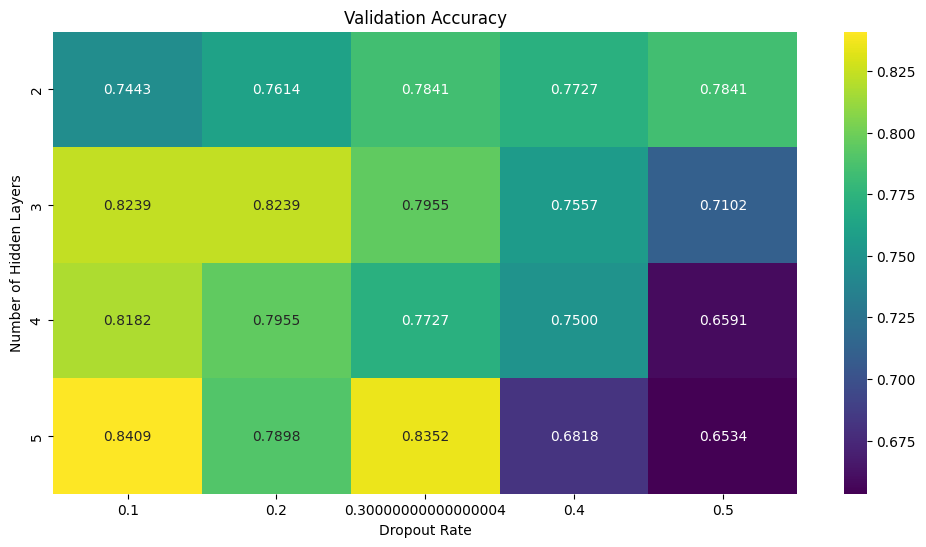

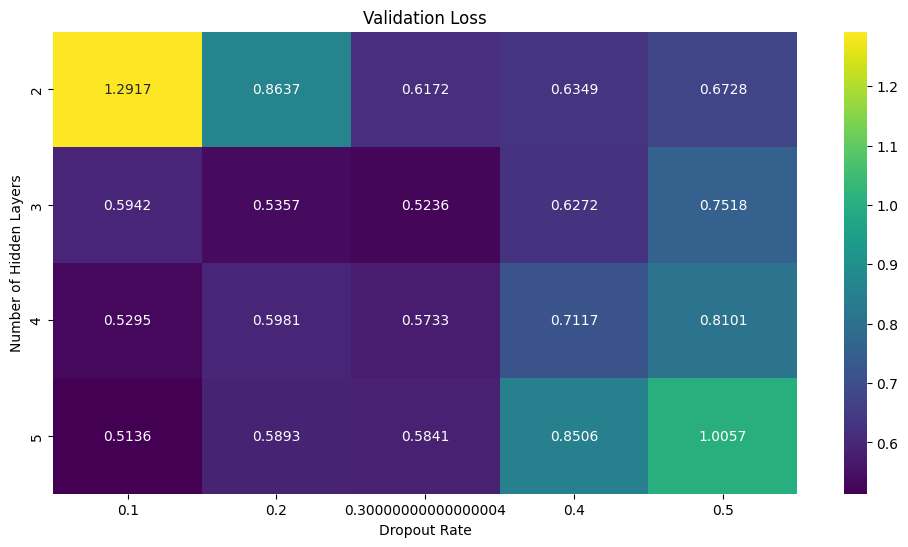

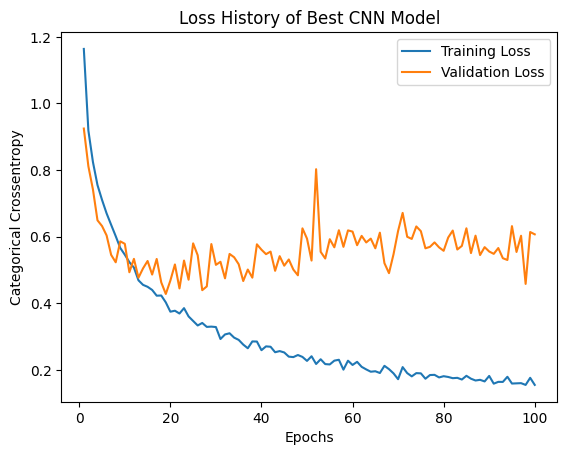

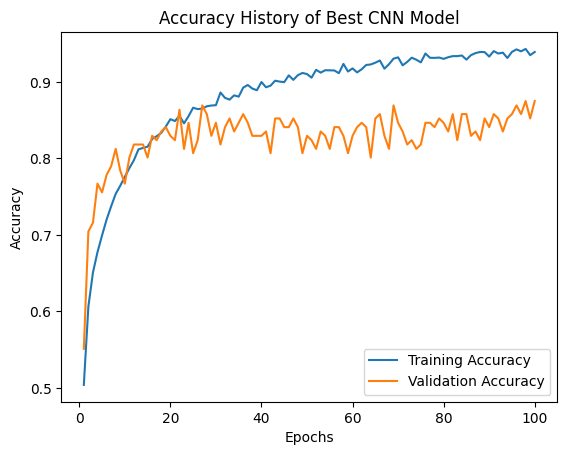

50/50 [==============================] - 0s 5ms/step - loss: 0.6211 - accuracy: 0.8279
Best CNN Model Test Loss: 0.6211054921150208
Best CNN Model Test Accuracy: 0.8279365301132202
50/50 [==============================] - 0s 3ms/step
Best CNN Model Ancillary Results
Precision: 0.8329
Recall: 0.8279
F1-Score: 0.8287
50/50 [==============================] - 0s 3ms/step
Classification Report for Best CNN Model:
              precision    recall  f1-score   support

        Bach       0.93      0.96      0.94       626
   Beethoven       0.77      0.76      0.77       446
      Chopin       0.55      0.71      0.62       118
      Mozart       0.83      0.74      0.78       385

    accuracy                           0.83      1575
   macro avg       0.77      0.79      0.78      1575
weighted avg       0.83      0.83      0.83      1575



In [7]:
# Grid Search Training Loop
dropout_values = np.linspace(0.1, 0.5, 5)
hidden_layer_values = [2, 3, 4, 5]

val_accuracies = np.zeros((len(hidden_layer_values), len(dropout_values)))
val_losses = np.zeros((len(hidden_layer_values), len(dropout_values)))

best_model = None
best_acc = -1
best_training_history = None
best_settings = None

for i, hidden_layers in enumerate(hidden_layer_values):
    for j, dropout_rate in enumerate(dropout_values):
        print(f"Training Dropout: {dropout_rate} Hidden Layer: {hidden_layers}")
        model, val_acc, val_loss, train_history = train_cnn_model(dropout_rate, hidden_layers)
        
        val_accuracies[i, j] = val_acc
        val_losses[i, j] = val_loss
        
        if val_acc > best_acc:
            best_model = model
            best_acc = val_acc
            best_training_history = train_history
            best_settings = (hidden_layers, dropout_rate)
            
# Heatmap for Validation Accuracy
plt.figure(figsize=(12, 6))
sns.heatmap(val_accuracies, annot=True, fmt=".4f", xticklabels=dropout_values, yticklabels=hidden_layer_values, cmap='viridis')
plt.title('Validation Accuracy')
plt.xlabel('Dropout Rate')
plt.ylabel('Number of Hidden Layers')
plt.show()

# Heatmap for validation loss
plt.figure(figsize=(12, 6))
sns.heatmap(val_losses, annot=True, fmt=".4f", xticklabels=dropout_values, yticklabels=hidden_layer_values, cmap='viridis')
plt.title('Validation Loss')
plt.xlabel('Dropout Rate')
plt.ylabel('Number of Hidden Layers')
plt.show()

# Retrain model on the best settings
EPOCHS = 100
hidden_layers, dropout_rate = best_settings
print(f"Best CNN Hidden Layers: {hidden_layers}")
print(f"Best CNN Dropout Rate: {dropout_rate}")
best_model, _, _, best_training_history = train_cnn_model(dropout_rate, hidden_layers, epochs=EPOCHS)

train_loss = best_training_history.history["loss"]
val_loss = best_training_history.history["val_loss"]

train_acc = best_training_history.history["accuracy"]
val_acc = best_training_history.history["val_accuracy"]

plt.plot(range(1,EPOCHS+1), train_loss, label="Training Loss")
plt.plot(range(1,EPOCHS+1), val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Categorical Crossentropy")
plt.legend()
plt.title("Loss History of Best CNN Model")
plt.show()

plt.plot(range(1,EPOCHS+1), train_acc, label="Training Accuracy")
plt.plot(range(1,EPOCHS+1), val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy History of Best CNN Model")
plt.show()

test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Best CNN Model Test Loss: {test_loss}")
print(f"Best CNN Model Test Accuracy: {test_accuracy}")

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate precision, recall, and F1-score
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
print("Best CNN Model Ancillary Results")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate and print classification report
report = classification_report(y_true, y_pred_classes, target_names=['Bach', 'Beethoven', 'Chopin', 'Mozart'])
print("Classification Report for Best CNN Model:")
print(report)

## Discussion of CNN model training
For the convolutional network, it seemed more was better. The network with the most hidden layers and least regularization was able to produce the best results on the validation data when trained for 20 epochs. Though 20 epochs may be somewhat of a small number of training steps, the models seem to hit close to their maximum validation accuracy after a few epochs anyways. The minimal amount of dropout needed for performance on the validation set is probably due to the fact that the model uses dropout in every single hidden layer, so 10% dropout for 5 hidden layers removes enough units for generalization to the validation set. Our group hypothesizes that a larger amount of epochs may slightly change the result, but the settings used to optimize the CNN are probably sufficient.

## LSTM Methodology
We will follow the exact same procedure for tuning and training the LSTM. Again, our group decided to limit the hyperparameter tuning to the two vital parameters of hidden layer number and dropout rate.

After optimizing the LSTM model we will compare the results to the CNN architecture for this dataset.

In [8]:
EPOCHS = 20
def train_lstm_model(dropout, hidden_layers, epochs=EPOCHS):
    lstm = model_api.opt2_lstm(4, hidden_layers, dropout_rate=dropout, max_len=100)
    history = lstm.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=1024, verbose=0)

    val_accuracy = history.history["val_accuracy"][-1]
    val_loss = history.history["val_loss"][-1]

    return lstm, val_accuracy, val_loss, history

Training Dropout: 0.1 Hidden Layer: 2
Training Dropout: 0.2 Hidden Layer: 2
Training Dropout: 0.30000000000000004 Hidden Layer: 2
Training Dropout: 0.4 Hidden Layer: 2
Training Dropout: 0.5 Hidden Layer: 2
Training Dropout: 0.1 Hidden Layer: 3
Training Dropout: 0.2 Hidden Layer: 3
Training Dropout: 0.30000000000000004 Hidden Layer: 3
Training Dropout: 0.4 Hidden Layer: 3
Training Dropout: 0.5 Hidden Layer: 3
Training Dropout: 0.1 Hidden Layer: 4
Training Dropout: 0.2 Hidden Layer: 4
Training Dropout: 0.30000000000000004 Hidden Layer: 4
Training Dropout: 0.4 Hidden Layer: 4
Training Dropout: 0.5 Hidden Layer: 4
Training Dropout: 0.1 Hidden Layer: 5
Training Dropout: 0.2 Hidden Layer: 5
Training Dropout: 0.30000000000000004 Hidden Layer: 5
Training Dropout: 0.4 Hidden Layer: 5
Training Dropout: 0.5 Hidden Layer: 5


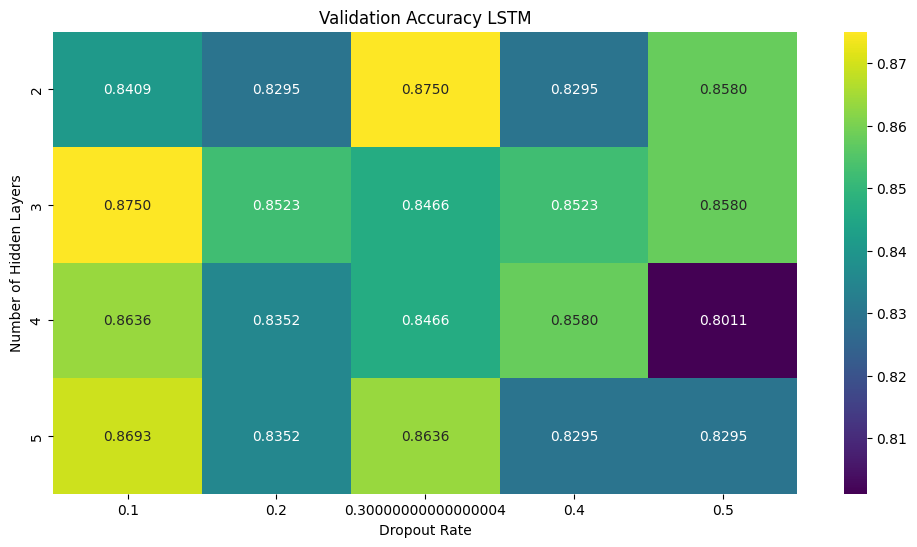

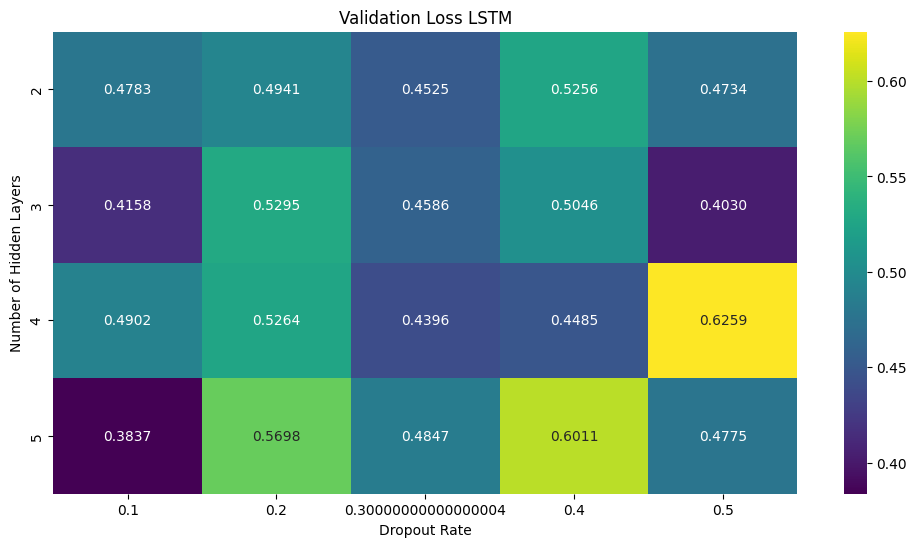

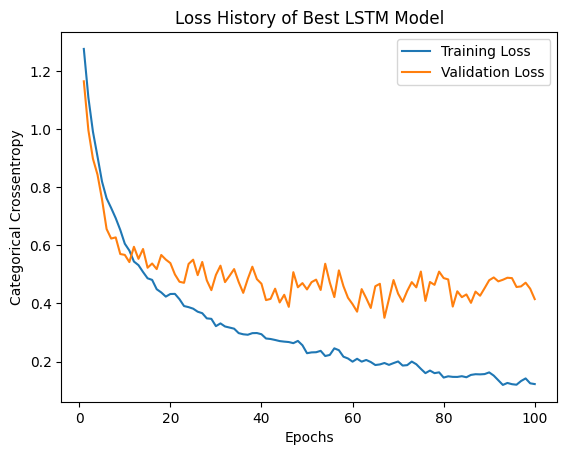

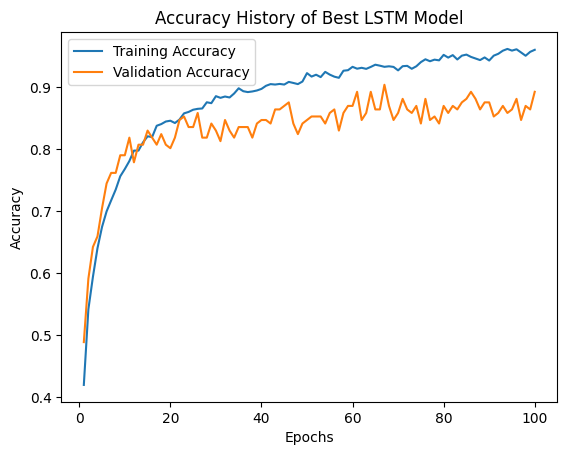

50/50 [==============================] - 1s 15ms/step - loss: 0.6889 - accuracy: 0.8222
Best LSTM Model Test Loss: 0.6889415383338928
Best LSTM Model Test Accuracy: 0.8222222328186035
50/50 [==============================] - 2s 15ms/step
Best LSTM Model Ancillary Results
Precision: 0.8214
Recall: 0.8222
F1-Score: 0.8207
50/50 [==============================] - 1s 15ms/step
Classification Report for Best LSTM Model:
              precision    recall  f1-score   support

        Bach       0.90      0.95      0.92       626
   Beethoven       0.81      0.73      0.77       446
      Chopin       0.64      0.73      0.68       118
      Mozart       0.77      0.74      0.76       385

    accuracy                           0.82      1575
   macro avg       0.78      0.79      0.78      1575
weighted avg       0.82      0.82      0.82      1575



In [9]:
# Grid Search Training Loop
dropout_values = np.linspace(0.1, 0.5, 5)
hidden_layer_values = [2, 3, 4, 5]

val_accuracies = np.zeros((len(hidden_layer_values), len(dropout_values)))
val_losses = np.zeros((len(hidden_layer_values), len(dropout_values)))

best_model = None
best_acc = -1
best_training_history = None
best_settings = None

for i, hidden_layers in enumerate(hidden_layer_values):
    for j, dropout_rate in enumerate(dropout_values):
        print(f"Training Dropout: {dropout_rate} Hidden Layer: {hidden_layers}")
        model, val_acc, val_loss, train_history = train_lstm_model(dropout_rate, hidden_layers, epochs=EPOCHS)

        val_accuracies[i, j] = val_acc
        val_losses[i, j] = val_loss

        if val_acc > best_acc:
            best_model = model
            best_acc = val_acc
            best_training_history = train_history
            best_settings = (hidden_layers, dropout_rate)

# Heatmap for Validation Accuracy
plt.figure(figsize=(12, 6))
sns.heatmap(val_accuracies, annot=True, fmt=".4f", xticklabels=dropout_values, yticklabels=hidden_layer_values, cmap='viridis')
plt.title('Validation Accuracy LSTM')
plt.xlabel('Dropout Rate')
plt.ylabel('Number of Hidden Layers')
plt.show()

# Heatmap for validation loss
plt.figure(figsize=(12, 6))
sns.heatmap(val_losses, annot=True, fmt=".4f", xticklabels=dropout_values, yticklabels=hidden_layer_values, cmap='viridis')
plt.title('Validation Loss LSTM')
plt.xlabel('Dropout Rate')
plt.ylabel('Number of Hidden Layers')
plt.show()

# Retrain model on the best settings
EPOCHS = 100
hidden_layers, dropout_rate = best_settings
print(f"Best LSTM Hidden Layers: {hidden_layers}")
print(f"Best LSTM Dropout Rate: {dropout_rate}")

best_model, _, _, best_training_history = train_lstm_model(dropout_rate, hidden_layers, epochs=EPOCHS)

train_loss = best_training_history.history["loss"]
val_loss = best_training_history.history["val_loss"]

train_acc = best_training_history.history["accuracy"]
val_acc = best_training_history.history["val_accuracy"]

plt.plot(range(1,EPOCHS+1), train_loss, label="Training Loss")
plt.plot(range(1,EPOCHS+1), val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Categorical Crossentropy")
plt.legend()
plt.title("Loss History of Best LSTM Model")
plt.show()

plt.plot(range(1,EPOCHS+1), train_acc, label="Training Accuracy")
plt.plot(range(1,EPOCHS+1), val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy History of Best LSTM Model")
plt.show()

test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Best LSTM Model Test Loss: {test_loss}")
print(f"Best LSTM Model Test Accuracy: {test_accuracy}")

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate precision, recall, and F1-score
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
print("Best LSTM Model Ancillary Results")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate and print classification report
report = classification_report(y_true, y_pred_classes, target_names=['Bach', 'Beethoven', 'Chopin', 'Mozart'])
print("Classification Report for Best LSTM Model:")
print(report)

## Discussion of LSTM model training
The LSTM model seems to thrive best at more hidden layers and a lower dropout rate just like the CNN. However, the ability for the LSTM to generalize at lower hidden layer counts with larger dropout rates should be noted. Moreover, it seems the higher hidden layer count actually needs lower dropout rates to realize performance, this may be due to the 20 epoch constraint used in the hyperparameter tuning. The 20 epoch constraint is hard to increase due to computational limitations of our desktops, however, the heatmap seems to indicate that the settings used for the LSTM should be sufficient.


## PrettyMIDI Model Results

The overall metrics for performance indicate that the Convolutional Neural Network was able to achieve a higher accuracy and lower loss than the LSTM model. This is further showcased in the overall Precision, Recall, and F1-Scores, as the CNN performs better than the LSTM in all of them. 

The Classification Reports produced for both models indicate that both perform well at identifying compositions and scores created by Bach. The same can also be true for compositions and scores created by Beethoven and Mozart. The Chopin labels have mixed results, the CNN has much higher precision but slightly lower recall than the LSTM. Chopin is the smallest class in the test set and the dataset, so the large gap in precision indicates the CNN's ability to better generalize on a small amount of data.  

In conclusion, the CNN seems to be able to outperform the LSTM architecture in this context. Our group finds this surprising as the LSTM in theory should be more suited to time-series prediction. Perhaps the small dataset of less than ten thousand examples doesn’t create the proper environment for the more complex LSTM cell parameters.

# Train Neural Networks on audio files.

In [10]:
# Import Pretty MIDI data
audio_data = np.load("AudioData/train_dataset.npz")

examples = audio_data['features']
labels = audio_data['labels']

print(examples.shape)
print(labels.shape)

(284, 2)
(284,)


In [1]:
from midi2audio import FluidSynth
import os

def convert_midi_to_audio(midi_dir, audio_dir):
    if not os.path.exists(audio_dir):
        os.makedirs(audio_dir)

    fs = FluidSynth()
    for midi_file in os.listdir(midi_dir):
        if midi_file.endswith(".midi") or midi_file.endswith(".mid"):
            midi_path = os.path.join(midi_dir, midi_file)
            audio_path = os.path.join(audio_dir, f"{os.path.splitext(midi_file)[0]}.wav")
            fs.midi_to_audio(midi_path, audio_path)
            print(f"Converted {midi_file} to {audio_path}")

midi_dir = extract_dir  # Assuming the MIDI files are directly in the extracted directory
audio_dir = '/mnt/data/Composer_Audio'
convert_midi_to_audio(midi_dir, audio_dir)

#perform feature extraction 

import librosa
import numpy as np

def extract_features(audio_dir):
    features = []
    labels = []

    for audio_file in os.listdir(audio_dir):
        if audio_file.endswith(".wav"):
            audio_path = os.path.join(audio_dir, audio_file)
            y, sr = librosa.load(audio_path, sr=None)

            # Mel spectrogram
            mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
            log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

            # Chroma features
            chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)

            # Tempo
            onset_env = librosa.onset.onset_strength(y=y, sr=sr)
            tempo, _ = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)

            # Combine features into one array
            feature_vector = np.concatenate((log_mel_spectrogram.flatten(), chroma_stft.flatten(), [tempo]))
            features.append(feature_vector)

            # Extract label from file name
            label = audio_file.split("_")[0]
            labels.append(label)

    return np.array(features), np.array(labels)

features, labels = extract_features(audio_dir)
print("Feature extraction complete.")

NameError: name 'extract_dir' is not defined